<a href="https://colab.research.google.com/github/benihime91/pytorch_retinanet/blob/master/Run_001_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

In this notebook, we implement [PyTorch RetinaNet](https://github.com/benihime91) for custom dataset. 

We will take the following steps to implement PyTorch RetinaNet on our custom data:
* Install PyTorch RetinaNet along with required dependencies.
* Download Custom Dataset.
* Write Training Configuation yaml file .
* Train  Detection Model .
* Use Trained PyTorch RetinaNet Object Detection For Inference on Test Images.


### **Setting up Colab :**

In [1]:
# What GPU do we have ?
!nvidia-smi

Sun Oct 11 06:18:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

# **Install Pytorch Retinanet and Dependencies** :

In [ ]:
# Clone the RetinaNet Repo
!git clone https://github.com/benihime91/pytorch_retinanet.git
# install dependencies
!pip install pytorch-lightning omegaconf wandb --quiet
!pip install git+https://github.com/albumentations-team/albumentations --quiet
!echo "[   OK   ] Installed all depedencies "

Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 1939 (delta 116), reused 108 (delta 43), pack-reused 1730
Receiving objects: 100% (1939/1939), 68.66 MiB | 6.70 MiB/s, done.
Resolving deltas: 100% (1280/1280), done.
     |████████████████████████████████| 481kB 2.8MB/s 
     |████████████████████████████████| 1.7MB 13.0MB/s 
     |████████████████████████████████| 829kB 23.5MB/s 
     |████████████████████████████████| 92kB 8.5MB/s 
     |████████████████████████████████| 276kB 30.4MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
     |████████████████████████████████| 122kB 26.3MB/s 
     |████████████████████████████████| 163kB 28.6MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 


In [5]:
#Update sys path to enclude the pytorch RetinaNet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("/content/pytorch_retinanet/")
%load_ext autoreload
%autoreload 2
%matplotlib inline

!echo "[   OK   ] Setup Done "

[   OK   ] Setup Done 


# **Prepare Pytorch Retinanet Object Detection Training Data**

We will use the **[BCCD Dataset](https://public.roboflow.com/object-detection/bccd)** from RoboFlow. There are 364 images across three classes.


To train on the custom dataset the data needs to be in either **csv** or **pascal-voc** format . Roboflow makes it easier to generate the datasets. We can directly download the datsets in required format.

We will download the dataset in **Pascal-VOC** format and then use in-built methods available in PyTorch Retinanet to convert our data into **csv** format.

In [6]:
#Downloading data from Roboflow
#UPDATE THIS LINK - get our data from Roboflow
%cd /content
!curl -L "https://public.roboflow.com/ds/vYOavmoHyM?key=byxE8x2t11" > roboflow.zip; unzip -qq roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   886  100   886    0     0   1202      0 --:--:-- --:--:-- --:--:--  1200
100 6087k  100 6087k    0     0  6263k      0 --:--:-- --:--:-- --:--:-- 6263k


In [7]:
#Set up paths 

#Path to where the Images are stored
TRAIN_IMAGE_PATH = "/content/train/"
VALID_IMAGE_PATH = "/content/valid/"
TEST_IMAGE_PATH  = "/content/test/"
#Path to where annotations are stored
TRAIN_ANNOT_PATH = "/content/train/"
VALID_ANNOT_PATH = "/content/valid/"
TEST_ANNOT_PATH  = "/content/test/"

In [9]:
import pandas as pd
from utils.pascal import convert_annotations_to_df
from PIL import Image
import cv2
import numpy as np

pd.set_option("display.max_colwidth", None)
np.random.seed(123)

## **Generate csv file from XML Annotations:**

In [11]:
#convert xml files to pandas DataFrames
train_df = convert_annotations_to_df(TRAIN_ANNOT_PATH, TRAIN_IMAGE_PATH, image_set="train")
valid_df = convert_annotations_to_df(VALID_ANNOT_PATH, VALID_IMAGE_PATH, image_set="test")
test_df  = convert_annotations_to_df(TEST_ANNOT_PATH, TEST_IMAGE_PATH, image_set="test")

!echo "[   DONE  ] DataFrame(s) Generated !"


def remove_invalid_annots(df):
    """
    Removes annotaitons where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

# removing annotations that are not valid annotations
!echo "[   INFO  ] Removing invalid annotations ... "
train_df = remove_invalid_annots(train_df)
valid_df = remove_invalid_annots(valid_df)
test_df = remove_invalid_annots(test_df)
!echo "[   DONE  ] OK !"

[   DONE  ] DataFrame(s) Generated !
[   INFO  ] Removing invalid annotations ... 
[   DONE  ] OK !


### **CSV Files are as follows :**

In [12]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/train/BloodImage_00047_jpg.rf.fc57c00b0a785b07d53c1a0cbc7d1e6d.jpg,416,416,WBC,181,127,249,224,3
1,/content/train/BloodImage_00047_jpg.rf.fc57c00b0a785b07d53c1a0cbc7d1e6d.jpg,416,416,Platelets,135,185,156,210,1
2,/content/train/BloodImage_00047_jpg.rf.fc57c00b0a785b07d53c1a0cbc7d1e6d.jpg,416,416,Platelets,168,228,189,252,1
3,/content/train/BloodImage_00047_jpg.rf.fc57c00b0a785b07d53c1a0cbc7d1e6d.jpg,416,416,Platelets,8,240,26,270,1
4,/content/train/BloodImage_00047_jpg.rf.fc57c00b0a785b07d53c1a0cbc7d1e6d.jpg,416,416,RBC,21,88,106,199,2


In [13]:
valid_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/valid/BloodImage_00344_jpg.rf.3092e1f75781e74953416874af6a2cf1.jpg,416,416,RBC,344,151,402,225,2
1,/content/valid/BloodImage_00344_jpg.rf.3092e1f75781e74953416874af6a2cf1.jpg,416,416,RBC,226,251,292,353,2
2,/content/valid/BloodImage_00344_jpg.rf.3092e1f75781e74953416874af6a2cf1.jpg,416,416,RBC,3,301,65,379,2
3,/content/valid/BloodImage_00344_jpg.rf.3092e1f75781e74953416874af6a2cf1.jpg,416,416,RBC,249,358,335,414,2
4,/content/valid/BloodImage_00344_jpg.rf.3092e1f75781e74953416874af6a2cf1.jpg,416,416,RBC,165,339,242,415,2


In [14]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/test/BloodImage_00369_jpg.rf.99ae139e5530a25980b7acdd56a4317c.jpg,416,416,RBC,179,250,241,354,2
1,/content/test/BloodImage_00369_jpg.rf.99ae139e5530a25980b7acdd56a4317c.jpg,416,416,RBC,255,263,317,331,2
2,/content/test/BloodImage_00369_jpg.rf.99ae139e5530a25980b7acdd56a4317c.jpg,416,416,RBC,7,218,81,305,2
3,/content/test/BloodImage_00369_jpg.rf.99ae139e5530a25980b7acdd56a4317c.jpg,416,416,RBC,83,266,146,365,2
4,/content/test/BloodImage_00369_jpg.rf.99ae139e5530a25980b7acdd56a4317c.jpg,416,416,RBC,5,289,77,383,2


In [15]:
#Paths where to save the generated dataframes
TRAIN_CSV = "/content/train_data.csv"
VALID_CSV = "/content/valid_data.csv"
TEST_CSV = "/content/test_data.csv"

# #Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=False)
valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

In [16]:
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df=pd.read_csv(TEST_CSV)

# **View Images from the Dataset** :

We can use the fn `visualize_boxes_and_labels_on_image_array` from the RetinaNet repo to visualize images and the bounding boxes over them. To use this function we need to first create a Label Map, which is a list that contains all the classes at index corresponding to the integer labels .

##**Let's now generate the Label Map which is used for visualization:**

In [17]:
from utils.pascal import generate_pascal_category_names

LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP

['__background__', 'Platelets', 'RBC', 'WBC']

##**Plot images with Bounding boxes over them**:

In [18]:
from utils import visualize_boxes_and_labels_on_image_array
import matplotlib.pyplot as plt

In [19]:
def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index
    """
    assert index <= len(dataframe), f"[  ERROR  ] Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs = dataframe.loc[dataframe.filename == fname]
    bbs  = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls  = locs["labels"].values
    return fname, bbs, cls

### **Image from Train Data:**

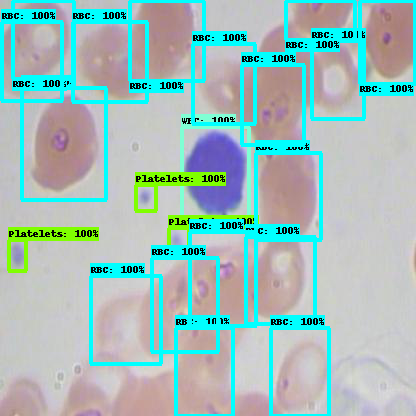

In [20]:
#grab image, boxe and class target
image, boxes, clas = grab_bbs_(train_df, index=0)

#load and normalize the image
image = Image.open(image)
image = np.array(image) / 255.

#draw boxes over the image
image = visualize_boxes_and_labels_on_image_array(
                image=image,
                boxes=boxes, 
                scores=None, 
                classes=clas,
                label_map=LABEL_MAP,
)

# # images are very large so-takes along time to 
# # render . Therefore, plot the images using 
# # matplotlib with a smaller figure size
# plt.figure(figsize=(15,15))
# plt.axis("off")
# plt.imshow(image);
image

### **Image from Validation data:**

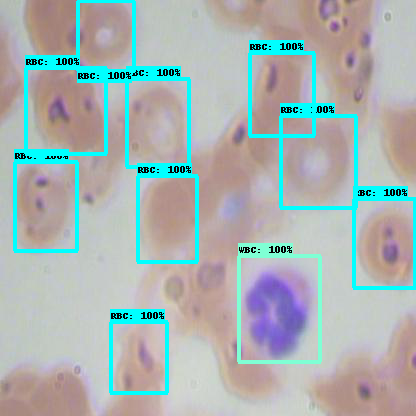

In [21]:
#grab image, boxe and class target
image, boxes, clas = grab_bbs_(valid_df, index=50)

#load and normalize the image
image = Image.open(image)
image = np.array(image) / 255.

#draw boxes over the image
image = visualize_boxes_and_labels_on_image_array(
                image=image,
                boxes=boxes, 
                scores=None, 
                classes=clas,
                label_map=LABEL_MAP,
)

# # images are very large so-takes along time to 
# # render . Therefore, plot the images using 
# # matplotlib with a smaller figure size
# plt.figure(figsize=(15,15))
# plt.axis("off")
# plt.imshow(image);
image

###**Image from Test Data:**

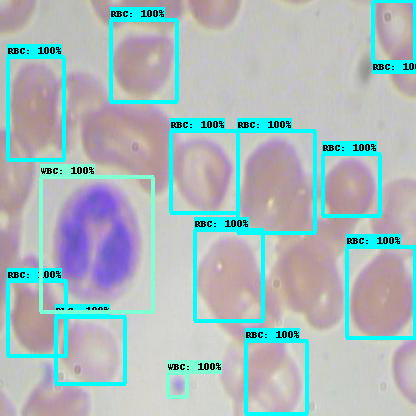

In [22]:
#grab image, boxe and class target
image, boxes, clas = grab_bbs_(test_df, index=100)

#load and normalize the image
image = Image.open(image)
image = np.array(image) / 255.

#draw boxes over the image
image = visualize_boxes_and_labels_on_image_array(
                image=image,
                boxes=boxes, 
                scores=None, 
                classes=clas,
                label_map=LABEL_MAP,
)

# # images are very large so-takes along time to 
# # render . Therefore, plot the images using 
# # matplotlib with a smaller figure size
# plt.figure(figsize=(15,15))
# plt.axis("off")
# plt.imshow(image);
image

#**Configure Custom PyTorch RetianNet Object Detection Training Configuration** :


In [23]:
!cat /content/pytorch_retinanet/hparams.yaml

###################################################################
# CONFIG FILE TO INSTANTIATE THE LIGHTNING MODEL :
###################################################################

# ============================================================== #
# RETINANET MODEL PARAMETERS
# ============================================================== #
# set the parameters to be passed on to the retianet mode here
# NOTE: the full set of arguemnts can be found in `retinanet/config.py` .
model:
  backbone_kind: resnet50 # backbone of the model
  num_classes: 90 # number of classes (excluding the background class)
  freeze_bn: True # wether to freeze the backone of the model
  min_size: 800 # Size of the smallest side of the image during training
  max_size: 1600 # Maximum size of the side of the image during training

# ============================================================== #
# DATASETS AND DATALOADERS :
# ============================================================== #
# the datase

In [24]:
from omegaconf import OmegaConf

#load in the hparams.ymal file using Omegaconf
hparams = OmegaConf.load("/content/pytorch_retinanet/hparams.yaml")

# ========================================================================= #
# MODIFICATION OF THE CONFIG FILE TO FIX PATHS AND DATSET-ARGUEMENTS :
# ========================================================================= #
#specify kind of data to use
hparams.dataset.kind = "csv"
#Paths to the csv files
hparams.dataset.trn_paths   = TRAIN_CSV
hparams.dataset.valid_paths = VALID_CSV
hparams.dataset.test_paths  = TEST_CSV
# number of classes in dataset excluding the 
# "__background__" class
hparams.model.num_classes = len(LABEL_MAP) - 1

#Changing optimizer paramters, 
hparams.optimizer = {
    "class_name": "torch.optim.SGD", 
    "params": {
        "lr": 0.02,
        "momentum": 0.9,
        "weight_decay" : 0.001,
        },
    }

print(OmegaConf.to_yaml(hparams))

model:
  backbone_kind: resnet50
  num_classes: 3
  freeze_bn: true
  min_size: 800
  max_size: 1600
dataset:
  kind: csv
  root_dir: false
  trn_paths: /content/train_data.csv
  valid_paths: /content/valid_data.csv
  test_paths: /content/test_data.csv
dataloader:
  train_bs: 2
  valid_bs: 30
  test_bs: 30
  args:
    num_workers: 0
    pin_memory: true
transforms:
- class_name: albumentations.HorizontalFlip
  params:
    p: 0.5
optimizer:
  class_name: torch.optim.SGD
  params:
    lr: 0.02
    momentum: 0.9
    weight_decay: 0.001
scheduler:
  class_name: torch.optim.lr_scheduler.ReduceLROnPlateau
  params:
    mode: min
    factor: 0.1
    patience: 5
    verbose: true
  interval: epoch
  frequency: 1
  monitor: val_loss



#**Instantiate Lightning-Module and Lightning-Trainer**

In [25]:
import time
import pytorch_lightning as pl

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import *
from pytorch_lightning.callbacks import *
from model import RetinaNetModel, LogCallback

# seed so that results are reproducible
pl.seed_everything(123)

123

## **Load in the Lighning-Trainer :**

In [27]:
# ============================================================ #
# INSTANTIATE LIGHTNING-TRAINER with CALLBACKS :
# ============================================================ #
# NOTE: 
# For a list of whole trainer specific arguments see : 
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html

#Logger
#check: https://pytorch-lightning.readthedocs.io/en/latest/loggers.html,for all supported loggers
#we will use wandb logger

#wandb API-KEY
!wandb login "a74f67fd5fae293e301ea8b6710ee0241f595a63"
#Wandb project name
PNAME = "bloood-cell-roboflow"
LOGGER = WandbLogger(name=f"{time.time()}", anonymous=True, project=PNAME)

#Learning-rate Logger to log the learning-rate to the logger
LR_LOGGER = LearningRateLogger(logging_interval="step")

#Model Checkpoint Callback, this callback will save checkpoints 
#each time our val loss decreases
fname =f"/content/checkpoints/"
os.makedirs(fname, exist_ok=True)
CHECKPOINT_CALLBACK = ModelCheckpoint(fname, mode="min", monitor="val_loss", save_top_k=3,)

#callback for early-stopping
EARLY_STOPPING_CALLBACK = EarlyStopping(mode="min", monitor="val_loss", patience=20, verbose=True)

#instantiate LightningTrainer
trainer = Trainer(precision=16, 
                  max_epochs=100,
                  gpus=1, 
                  logger=[LOGGER],
                  early_stop_callback=EARLY_STOPPING_CALLBACK, 
                  checkpoint_callback=CHECKPOINT_CALLBACK,
                  callbacks=[LogCallback(), LR_LOGGER], 
                  weights_summary=None,
                  terminate_on_nan=True, 
                  benchmark=True,
                  );

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


GPU available: True, used: True
[10/11 06:16:47] lightning INFO: GPU available: True, used: True
TPU available: False, using: 0 TPU cores
[10/11 06:16:47] lightning INFO: TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[10/11 06:16:47] lightning INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
[10/11 06:16:47] lightning INFO: Using native 16bit precision.


##**Load in the Lighning-Module using the hparams file modified above & Start Train :**

In [ ]:
# Instantiate lightning-module
litModel = RetinaNetModel(hparams=hparams)

In [ ]:
!echo "[   START   ] START TRAINING ... "

#TIP: if using wandb logger go to wandb dashboard to view live logs
trainer.fit(litModel)

!echo "[    END    ] TRAINING COMPLETE ! "

#**Evaluating the trained-model using COCO-API Metrics** : 

In [ ]:
# Evaluations results on the test/ validation dataset(if test dataset is not given)
# using COCO API
!echo "[   START   ] START EVALUATION OF MODEL ON TEST IMAGES USING COCO-API ... "
trainer.test(litModel)
!echo "[    END    ] DONE EVALUATING MODEL ON TEST IMAGES USING COCO-API ! "

# **Export the model weights** :

In [ ]:
import torch

PATH = f"/content/trained_weights.pth"
torch.save(litModel.model.state_dict(), PATH)

#**Load PyTorch Model from the trained Lightning-Module weights :**

In [ ]:
from retinanet import Retinanet

state_dict = torch.load(PATH)

MODEL = Retinanet(num_classes=hparams.model.num_classes, backbone_kind=hparams.model.backbone_kind)
MODEL.load_state_dict(state_dict)
MODEL.to("cuda:0");

# **Run Inference on Test Images with Custom PyTroch Object Detector**

In [ ]:
from PIL import Image
import numpy as np
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from utils import visualize_boxes_and_labels_on_image_array

@torch.no_grad()
def get_preds(path, threshold=0.6,):
    """
    Generates predictions on the given image from the given path.
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    INFER_TRANSFORMS = A.Compose([A.ToFloat(max_value=255.0, always_apply=True),
                                  ToTensorV2(always_apply=True)
                                  ])
    
    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"].to("cuda:0")
    PREDICTIONS = MODEL.predict([TENSOR_IMAGE])
    #print(PREDICTIONS[0])
    return PREDICTIONS[0]

def detect(image_path, threshold=0.6):
    """
    Generate detections on the image that is present in 
    the given image path

    Args:
        image_path: Path to the input Image
        threshold: Score threshold to filter predictions
        nms_threshold: NMS threshold

    Returns: a PIL image containg the original Image and
             bounding boxes draw over it.
    """
    
    # visualize_boxes_and_labels_on_image_array function
    # expects the pixels values of the image to be in 
    # range [0,1] so be divide the loaded image by 255.0
    # to noramlize the co-ordinates
    # load the image as numpy array
    image = Image.open(image_path)
    image = np.array(image) / 255.
    # Generate predictions for the given image
    preds = get_preds(image_path, threshold,)
    # print(preds)
    # Filter predictions
    boxes, labels, scores = preds["boxes"], preds["labels"], preds["scores"]
    mask = scores > threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    return boxes.cpu().numpy(), labels.cpu().numpy(), scores.cpu().numpy()

In [ ]:
IMAGE, REAL_BOXES, REAL_LABELS = grab_bbs_(test_df, index=200)
IMAGE = Image.open(IMAGE)
IMAGE = np.array(IMAGE) / 255.

#draw boxes over the image
REAL_IMAGE = visualize_boxes_and_labels_on_image_array(
                image=IMAGE,
                boxes=REAL_BOXES, 
                scores=None, 
                classes=REAL_LABELS,
                label_map=LABEL_MAP,
)

REAL_IMAGE

PATH = test_df.filename[200]
THRESHOLD = 0.7

PRED_BOXES, PRED_LABELS, PRED_SCORES = detect(PATH, THRESHOLD,)

PRED_IMAGE = visualize_boxes_and_labels_on_image_array(
                image=IMAGE, 
                boxes=PRED_BOXES, 
                scores=PRED_SCORES,
                classes= PRED_LABELS,
                label_map=LABEL_MAP,
                )

In [ ]:
!echo "[ INFERENCE ] ORIGINAL IMAGE : "

REAL_IMAGE

In [ ]:
!echo "[ INFERENCE ] PREDICTIONS : "

PRED_IMAGE